# Satellite Precipitation Products correction model application Notebook

In [ ]:
# Library imports cell

from pacha.utils import instruments as iutils
from pacha.utils import file_utils as futils
from pacha.visualisation import geospatial as gvis
from pacha.visualisation import statistical as svis
from pacha.utils import visualisation as vutils
from pacha.utils import geospatial as gutils
from pacha.utils import temporal as tutils
from pacha.data_sources import satellite_loaders as sload
from pacha.L3_processing import regrid as l3reg
import importlib
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
from scipy.signal import convolve2d
import matplotlib.gridspec as gridspec
from datetime import timedelta as td
from pacha.merging import quantile_matching as qmatch
import copy
import warnings
from cartopy import crs as ccrs
from pacha.utils import metrics
from scipy.spatial import distance
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle
from datetime import datetime
import os
from sklearn.cluster import KMeans
import numpy as np
from pacha.utils import ml_utils as aiutils
from datetime import datetime as dt
import cartopy.feature as cfeature


importlib.reload(metrics)
importlib.reload(qmatch)
importlib.reload(iutils)
importlib.reload(gvis)
importlib.reload(gutils)

<module 'PREDICT.utils.geospatial' from '/home/admingosset/miniconda3/envs/artrev/lib/python3.13/site-packages/PREDICT/utils/geospatial.py'>

In [2]:
# Specific functions definition

def infer_step_length(df):
    step_length = np.median(np.diff(df.index))
    return pd.to_timedelta(step_length)

def average_radar_inside_gauge_timesteps(gau_df, rad_df):
    step_length = infer_step_length(gau_df)
    min_val = rad_df.rain_rate.min()
    matched_rad = rad_df.replace(min_val, 0).groupby(pd.Grouper(freq=step_length)).mean()
    matched_rad.index = matched_rad.index + step_length
    return gau_df, matched_rad

def based_on_scope_retrieve_gauge_radar_data(scopy, gauges, radar):
    ids = scopy.index.tolist()

    dfs_by_id = {id:[] for id in ids}

    if len(scopy.index) <= 1:
        nlist = scopy.loc[scopy.index[0], 'dates']

    else:
        nlist = sorted(list(set(np.concatenate([l for l in scopy.loc[:, 'dates'].tolist()]))))

    idxs_by_date = {d: [] for d in nlist}
    for date in nlist:
        for idx in scopy.index:
            if date in scopy.loc[idx, 'dates']:
                idxs_by_date[date].append(idx)

    for date in nlist:
        ds_rad = radar.load_sample(date)
        for idx in idxs_by_date[date]:
            long, latg = gauges.get_coords_station(idx)
            rad_df = gutils.ds_to_df_at_point(ds_rad, (long, latg))
            gau_df = gauges.data.loc[date, idx]
            #rad_matched, gau_matched = tutils.align_dataframes_by_time_fixed(rad_df, gau_df)
            gau_matched, rad_matched = average_radar_inside_gauge_timesteps(gau_df, rad_df)
            gau_rate = gau_matched * 10
            rad_gau_df = pd.concat([rad_matched, gau_rate], axis=1)
            dfs_by_id[idx].append(rad_gau_df)

    return dfs_by_id


def visualize_scope(scopy, gauges, ax=None, fig=None):
    if len(scopy.index) <= 1:
        nlist = scopy.loc[scopy.index[0], 'dates']
    
    else:
        nlist = sorted(list(set(np.concatenate([l for l in scopy.loc[:, 'dates'].tolist()]))))
    
    if (fig is None) or (ax is None):
        fig = plt.figure(figsize=(10,3))
        ax = fig.add_subplot(111)
    
    max_date = pd.to_datetime(nlist).max()
    min_date = pd.to_datetime(nlist).min()
    
    monthly_accs = gauges.data.loc[min_date:max_date, scope.index].groupby(pd.Grouper(freq='1m')).sum().replace(0, np.nan)
    
    mean = monthly_accs.mean(axis=1)
    ax.plot_date(mean.index, mean.to_numpy(), fmt= '-k')
    max_accs = mean.max()/2
    ax.scatter(pd.to_datetime(nlist), max_accs * np.ones_like(np.array(nlist), dtype=float), marker='o', s=2000, alpha=0.1, edgecolors='none')
    ax.set_title('Mean monthly accumulations and dates from scope')
    ax.set_ylabel('mm/month')
    ax.set_xlabel('Time')
    return

def simple_romulo_plot(df_data, ids_order=None, columns_to_scale_differently=None, solo_scale=False, **kwargs):
    """
    Plots data from a DataFrame with optional scaling for selected columns.

    This function creates a series of plots for each column in the DataFrame. It supports
    custom scaling for specified columns and can apply a uniform scale across all columns.

    Parameters:
    - df_data (pd.DataFrame): The DataFrame containing the data to plot.
    - ids_order (list, optional): A list specifying the order of columns to plot. If None, the DataFrame's column order is used.
    - columns_to_scale_differently (list, optional): Columns that should be scaled differently from the rest. If solo_scale is True, this is ignored.
    - solo_scale (bool): If True, each column is scaled independently. Defaults to False.
    - **kwargs: Additional keyword arguments to pass to the plotting function.

    Returns:
    - None: Displays a matplotlib plot.
    """
    if not isinstance(df_data, pd.DataFrame):
        raise ValueError("df_data must be a pandas DataFrame.")

    if solo_scale:
        columns_to_scale_differently = df_data.columns.tolist()

    if columns_to_scale_differently is None:
        columns_to_scale_differently = []

    if not isinstance(columns_to_scale_differently, list):
        columns_to_scale_differently = [columns_to_scale_differently]

    if ids_order is None:
        ids_order = df_data.columns.tolist()

    df_data = df_data.loc[:, ids_order]
    cols_in = [col in columns_to_scale_differently for col in ids_order]

    v_min = df_data.loc[:, ~np.array(cols_in)].min().min() if not solo_scale else None
    v_max = df_data.loc[:, ~np.array(cols_in)].max().max() if not solo_scale else None

    n_ids = len(ids_order)
    fig, axes = plt.subplots(nrows=n_ids, sharex=True, figsize=[10, n_ids / 3])
    
    if n_ids == 1:
        axes = [axes]
    
    for uni_id, ax in zip(ids_order, axes):
        data_id = df_data.loc[:, uni_id].to_numpy()
        to_plot = np.reshape(data_id, [len(data_id), 1])
        vmin = to_plot.min() if uni_id in columns_to_scale_differently or solo_scale else v_min
        vmax = to_plot.max() if uni_id in columns_to_scale_differently or solo_scale else v_max
        ax.imshow(to_plot.T, vmin=vmin, vmax=vmax, aspect='auto')
        ax.set_yticks([0])
        ax.set_yticklabels([uni_id])

    xlocs = np.arange(len(df_data.index))
    xlabs = df_data.index.astype(str)
    
    if len(xlocs) > 10:
        step = len(xlocs) // 10
        xlocs = xlocs[::step]
        xlabs = xlabs[::step]

    plt.xticks(xlocs, xlabs, rotation='vertical')
    plt.subplots_adjust(hspace=0)
    plt.show()


def visualize_fuser(fuser, params, x=np.linspace(0, 10, 100), label=None, ax=None):
    if fuser.fusing_params['sep_land_sea']:
        land_params = params['land_params']
        sea_params = params['sea_params']
        label_sea = f'{label}_sea_params' if label is not None else ""
        label_land = f'{label}_land_params' if label is not None else ""
        fuser_copy = copy.deepcopy(fuser)
        fuser_copy.fusing_params['sep_land_sea'] = False
        visualize_fuser(fuser_copy, land_params, x=x, label=label_land, ax=ax)
        visualize_fuser(fuser_copy, sea_params, x=x, label=label_sea, ax=ax)
    else:
        if ax is None:
            ax = plt.gca()
        if 'land' in label:
            ls = '-'
        elif 'sea' in label:
            ls = '--'
        else:
            ls = '-.'
        ax.plot(x, fuser.low_level_applier(x, params), label=label, ls=ls)
        return


def decide_type_plot(ds):
    dims = ds.dims
    ndims = len(dims)
    if ndims == 1:
        return 'time_series_plot'
    elif ndims == 2:
        return 'spatial_plot'
    else:
        raise ValueError(f'{ndims} dims in dataset, not yet taken into account')


def plot_ds(ds, joint=False, plot_map=True, match_scale=True, pcp_var=None, vmmax=None):
    vars = list(ds.data_vars)
    nvars = len(vars)

    global_min = np.min(np.array([ds[var].min().values for var in vars]))
    global_max = np.max(np.array([ds[var].max().values for var in vars]))

    plot_type = decide_type_plot(ds)

    figsize = ((7+2)*nvars, 7)
    fig, axes = plt.subplots(1,
                             nvars,
                             subplot_kw=dict(projection=ccrs.PlateCarree()),
                             figsize=figsize)

    for i in range(nvars):
        ax = axes[i]
        var = vars[i]
        if plot_map:
            gvis.plot_simple_map(ax=ax)
        vmin, vmax = ds[var].min().values, ds[var].max().values

        if match_scale:
            vmin, vmax = global_min, global_max
        if vmmax is not None:
            vmax = vmmax
        ds[var].plot(x='lon', y='lat', ax=ax, vmin=vmin, vmax=vmax)
        ax.set_title(var)
    return


def from_ds_calc_single_step_spatial_correl(ds, ref_var='rain_rate'):
    tvar = ds.time.to_numpy()
    corr_list = [ds.isel({'time':i}).to_dataframe().loc[:, vars].corr().loc[:, ref_var] for i in range(len(tvar))]
    correl_df = pd.concat(corr_list, axis=1).T
    correl_df.index = tvar
    return correl_df


def calc_score_for_ds_multip_vars(ds, score_fct):
    ds_qmp = ds.drop_vars('precipitationCal')
    ds_nor = ds.drop_vars('precipitationCal_matched')
    
    tvar = ds.time.to_numpy()
    
    nsteps = len(tvar)
    rb_qmp = [score_fct(ds_qmp.isel({'time': i}), char_pcp='rain') for i in range(nsteps)]
    rb_nor = [score_fct(ds_nor.isel({'time': i}), char_pcp='rain') for i in range(nsteps)]
    score_key = list(rb_qmp[0].keys())[0]
    rb_qmp = [i[score_key] for i in rb_qmp]
    rb_nor = [i[score_key] for i in rb_nor]
    
    scores_dict = {'time': tvar,
                   'rbias_qmp': rb_qmp,
                   'rbias_nor': rb_nor}
    
    df_score = pd.DataFrame.from_dict(scores_dict)
    df_score = df_score.set_index('time')
    return df_score


def single_array_2dconv(arr):
    arr = convolve2d(arr, kernel, mode='same')
    return arr


def plot_median_2_quantiles(ds, var, ax=None, quantiles=[0.25, 0.75], c='b', threshold=0, **kwargs):
    if ax is None:
        ax = plt.gca()
    ds = ds.where(ds > threshold)
    ds[var].median(dim=['lat', 'lon']).plot(c=c, ax=ax, **kwargs)
    df = ds[var].quantile(quantiles, dim=['lon', 'lat']
                          ).to_dataframe().unstack().transpose()
    quant1 = df.iloc[:, 0].values
    quant2 = df.iloc[:, 1].values
    time = df.iloc[:, 0].loc[var].index.to_numpy()
    ax.fill_between(time, quant1, quant2, color=c, alpha=0.2)
    return


def calc_dist_to_median(ds, char_pcp='rain', threshold=.5):
    fields = list(ds.keys())
    if len(fields) != 2:
        raise ValueError('for this function to work a dataset with two variables must be input, here there are ' +
                         str(len(fields)) + ' fields')

    idx_pcp = [i for i in range(0, len(fields)) if char_pcp in fields[i]][0]
    field1 = fields.pop(idx_pcp)
    field2 = fields[0]
    cond_median = (ds.where(ds > threshold)).median(dim=['lat', 'lon'])
    dist_to_median = cond_median[field2] - cond_median[field1]
    dist_to_median = dist_to_median.values
    out_dict = {'distance_to_the_median': dist_to_median}
    return(out_dict)



def add_dist_metric(grid, lat0=None, lon0=None):
    """
    Add distance metric to the input grid.
    The distance is calculated as the euclidean distance from the grid cell to the specified coordinates (lat0, lon0).
    If no coordinates are specified, the mean latitude and longitude of the grid are used.

    Parameters
    ----------
    grid: xarray.DataArray
        Input grid with coordinates 'lat' and 'lon'.
    lat0: float, optional
        Latitude of the reference point. Default is None.
    lon0: float, optional
        Longitude of the reference point. Default is None.

    Returns
    -------
    xarray.Dataset
        The input grid with an additional distance metric ('dists') calculated as the euclidean distance from the grid
        cell to (lat0, lon0).
    """
    if (lat0 is None) or (lon0 is None):
        lat0 = grid.lat.mean()
        lon0 = grid.lon.mean()

    shape = (grid.lat.shape[0], grid.lon.shape[0])
    full_coords = list(itertools.product(grid.lat, grid.lon))

    center = [[lat0, lon0]]
    dists = distance.cdist(full_coords, center).reshape(shape)
    if isinstance(grid, xr.DataArray):
        test_to_add = grid.to_dataset(name='rain_rate')
    else:
        test_to_add = grid.copy()
    test_to_add['dists'] = (['lat', 'lon'], dists)
    return test_to_add


def get_lon_lat_dist(test_L2):
    """
    Calculate the distance between the minimum and maximum longitude and latitude in a given xarray dataset and the
    center of the array.
    Also return the coordinates (latitude, longitude) of the center of the bounding box defined by the min and max
    lat and lon.

    Parameters:
    - test_L2 (xarray.Dataset): xarray dataset containing longitude and latitude coordinates.

    Returns:
    - dist (float): distance between min and max longitude and latitude in the xarray dataset.
    - (lat0, lon0) (tuple): coordinates of the center of the bounding box defined by the min and max lat and lon.
    """
    lon_max = test_L2.lon.max()
    lat_max = test_L2.lat.max()
    lon_min = test_L2.lon.min()
    lat_min = test_L2.lat.min()

    dist_lon = ((lon_max - lon_min) / 2).data
    dist_lat = ((lat_max - lat_min) / 2).data

    dist = (dist_lon + dist_lat) / 2

    lon0 = ((lon_max + lon_min) / 2).data
    lat0 = ((lat_max + lat_min) / 2).data
    return (dist, (lat0, lon0))


def calculate_features_for_clustering(x, threshold=1.5):
    
    if not isinstance(x, (xr.Dataset, xr.DataArray)):
        raise TypeError(f"input isn't of valid type, valid types are xr.Dataset or xr.DataArray,\nx is {type(x)}")
    
    needed_dims = ['lat', 'lon']
    
    is_ds = isinstance(x, xr.Dataset)
    is_da = isinstance(x, xr.DataArray)
    
    if is_ds:
        dvars = list(x.data_vars)
        dims = x[dvars[0]].dims
    if is_da:
        dims = x.dims
    
    
    present_dims = set(dims)
    
    if not all(x in present_dims for x in needed_dims):
        raise TypeError(f'needed dims are {needed_dims}, x only has {present_dims}')
    
    if is_ds:
        dvars = list(x.data_vars)
        single_tstep = x[dvars[0]].isel({"time":0})
        cols = dvars
    if is_da:
        try:
            single_tstep = x.isel({'time':0})
        except Exception as e:
            print(e)
            print('defaulting to single step issue')
            single_tstep = x
        cols = [x.name]
    
    nvalid_pixels = single_tstep.count().values
    support_over_threshold = ((x > threshold).sum(dim=['lat', 'lon']))
    
    spm = (x.mean(dim=['lat', 'lon'])).to_dataframe().loc[:, cols]
    sup = (support_over_threshold/nvalid_pixels).to_dataframe().loc[:, cols]
    std = x.std(dim=['lat', 'lon']).to_dataframe().loc[:, cols]
    cvr = std/spm
    
    features = [spm, sup, std, cvr]
    feat_names = ['spm', 'sup', 'std', 'cvr']
    
    #spm.columns = [f'spm_{i}' for i in cols]
    #sup.columns = [f'sup_{i}' for i in cols]
    #std.columns = [f'std_{i}' for i in cols]
    #cvr.columns = [f'cvr_{i}' for i in cols]
    
    features_by_var = {col: None for col in cols}
    for col in cols:
        feats = pd.concat([feature.loc[:, col] for feature in features], axis=1)
        feats.columns = feat_names
        features_by_var[col] = feats
    return features_by_var


def save_to_pickle(model, directory):
    # Get the current date and time
    now = datetime.now()
    timestamp = now.strftime("%Y%m%d_%H%M%S")
    
    # Create the filename
    filename = f'k_means_model_{timestamp}.pkl'
    
    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)
    
    # Full path to save the model
    filepath = os.path.join(directory, filename)
    
    # Save the model
    with open(filepath, 'wb') as file:
        pickle.dump(model, file)
        
    print(f"Model saved to {filepath}")


def load_from_pickle(filepath):
    # Load the model from the specified file
    with open(filepath, 'rb') as file:
        model = pickle.load(file)
    return model


def are_models_equal(model1, model2):
    attributes = [
        'n_clusters', 'cluster_centers_', 'labels_', 
        'inertia_', 'n_iter_', 'random_state'
    ]
    
    for attr in attributes:
        if not np.array_equal(getattr(model1, attr, None), getattr(model2, attr, None)):
            return False
    return True


def subdivide_dataset(ds, nsubdivisions):
    """
    Subdivide the given dataset into nsubdivisions x nsubdivisions equal parts.
    
    Parameters:
    ds (xarray.Dataset): The input dataset.
    nsubdivisions (int): The number of subdivisions along each dimension (lat and lon).
    
    Returns:
    List[xarray.Dataset]: A list of subdivided datasets.
    """
    lon_splits = np.array_split(ds.lon, nsubdivisions)
    lat_splits = np.array_split(ds.lat, nsubdivisions)
    
    subsets = []
    for i in range(nsubdivisions):
        for j in range(nsubdivisions):
            subset = ds.sel(lon=lon_splits[j], lat=lat_splits[i])
            subsets.append(subset)
    
    return subsets

<xarray.Dataset> Size: 71MB
Dimensions:           (time: 5568, lon: 33, lat: 32)
Coordinates:
  * time              (time) datetime64[ns] 45kB 2021-01-13 ... 2022-12-26T23...
  * lon               (lon) float32 132B -54.25 -54.15 -54.05 ... -51.15 -51.05
  * lat               (lat) float32 128B 3.55 3.65 3.75 3.85 ... 6.45 6.55 6.65
    elevation         float64 8B ...
Data variables:
    precipitationCal  (time, lon, lat) float32 24MB ...
    rain_rate         (time, lat, lon) float64 47MB ...
Attributes:
    DimensionNames:    time,lon,lat
    Units:             mm/hr
    units:             mm/hr
    CodeMissingValue:  -9999.9

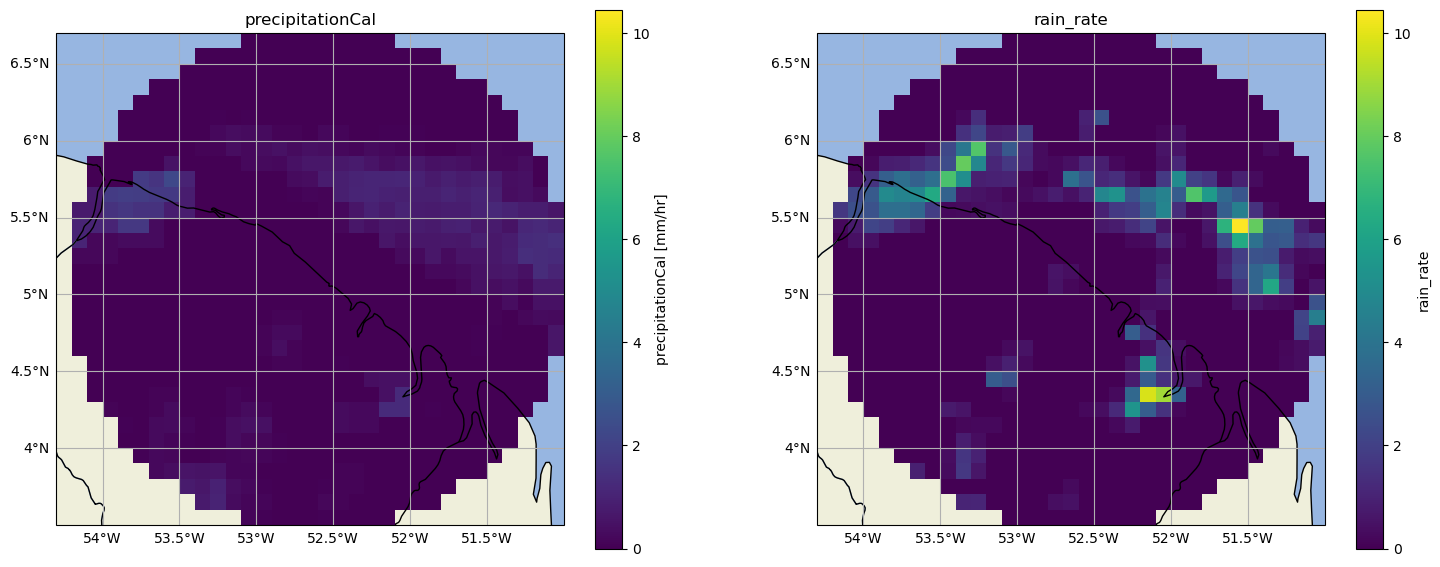

In [3]:
fpath_calib = 'calibration_set_v2.nc'
ds_calib = xr.open_dataset(fpath_calib)

display(ds_calib)
mask = ~ np.isnan(ds_calib.precipitationCal.isel(time=0))
ds_calib = ds_calib.fillna(0).where(mask)
gvis.plot_ds(ds_calib.isel({'time':0}))

In [4]:
### Determine your fuser

def test_func(x, a, b, c):
    return a*x**2 + b*x + c
fuser = qmatch.Fuser({'method': 'quantile_matching_by_parts', 'reference_variable': 'rain_rate', 'sep_land_sea':True, 'func': test_func})

In [5]:
### method 2 : load saved classifier, train pdf matching params, check results

ds = copy.deepcopy(ds_calib)
#train = train.where(train.precipitationCal>0)
#test = test.where(test.precipitationCal>0)

train, test = aiutils.split_dataset(ds)

# initialize kmeans
#kmeans = load_from_pickle('kmean_models/k_means_model_20240801_110831.pkl')

# initialize kmeans
kmeans = KMeans(n_clusters=3, random_state=12)
nclusters = kmeans.n_clusters

#determine features with no nans
features_df = calculate_features_for_clustering(train)['precipitationCal'].dropna()

#train kmeans
kmeans.fit(features_df)


nclusters = kmeans.n_clusters

#determine features with no nans
features_df = calculate_features_for_clustering(train)['precipitationCal'].dropna()

#add labels
features_df.loc[:, 'label'] = kmeans.predict(features_df)

#separate time steps by label
dates_by_label = {i: sorted(features_df.loc[features_df.label==i].index) for i in range(nclusters)}

#separate dataset by labels
dss_by_label = {i: train.sel({'time': dates_by_label[i]}) for i in range(nclusters)}

#calculate pdf matching params by label
params_by_label = {i: fuser.calculate_fusing_params(dss_by_label[i]) for i in range(nclusters)}

#export train matched dss by label
train_resulting_dss = {i: fuser.export_matching_ds(dss_by_label[i]) for i in range(nclusters)}

#ensure no duplicates and set them to be merged
train_land_dss = []
for label in range(nclusters):
    fused_ds = train_resulting_dss[label]
    land_ds = fused_ds.drop_duplicates('time')
    train_land_dss.append(land_ds)

#merge them
train_merged = xr.merge(train_land_dss)

#bias evaluation
no_match_bias = metrics.calc_rel_bias(train_merged.drop_vars('precipitationCal_matched'), char_pcp='rain')
matched_bias = metrics.calc_rel_bias(train_merged.drop_vars('precipitationCal'), char_pcp='rain')

print('for train dataset')
print(f'no matching:\t{no_match_bias}\nmatching:\t{matched_bias}')

#apply to testing dataset
features_test = calculate_features_for_clustering(test)['precipitationCal'].dropna()

features_test.loc[:, 'label'] = kmeans.predict(features_test)

#separate time steps by label
dates_by_label_test = {i: sorted(features_test.loc[features_test.label==i].index) for i in range(nclusters)}

#separate dataset by labels
dss_by_label_test = {i: test.sel({'time': dates_by_label_test[i]}) for i in range(nclusters)}

#export test matched dss by label
test_resulting_dss = {i: fuser.export_matching_ds(dss_by_label_test[i], params=params_by_label[i]) for i in range(nclusters)}

#ensure no duplicates and set them to be merged
test_land_dss = []
for label in range(nclusters):
    fused_ds = test_resulting_dss[label]
    land_ds = fused_ds.drop_duplicates('time')
    test_land_dss.append(land_ds)

#merge them
test_merged = xr.merge(test_land_dss)

#bias evaluation
no_match_bias = metrics.calc_rel_bias(test_merged.drop_vars('precipitationCal_matched'), char_pcp='rain')
matched_bias = metrics.calc_rel_bias(test_merged.drop_vars('precipitationCal'), char_pcp='rain')

print('\nfor test dataset')
print(f'no matching:\t{no_match_bias}\nmatching:\t{matched_bias}')


4454 1113


/home/admingosset/miniconda3/envs/artrev/lib/python3.13/site-packages/PREDICT/merging/quantile_matching.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_func, x, y, maxfev=100000)
/home/admingosset/miniconda3/envs/artrev/lib/python3.13/site-packages/PREDICT/merging/quantile_matching.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_func, x, y, maxfev=100000)


for train dataset
no matching:	{'relative_bias': np.float64(-0.1429)}
matching:	{'relative_bias': np.float64(0.0055)}

for test dataset
no matching:	{'relative_bias': np.float64(-0.1562)}
matching:	{'relative_bias': np.float64(0.0044)}


In [6]:
params_by_label

{0: {'land_params': {'method': 'qmatch_by_parts',
   'offset': array(6.03374106e-09),
   'p1_popt': array([ 1.51201247e-300, -3.70756938e-309, -2.19661586e-320]),
   'p2_popt': array([-0.04218004,  2.6982542 ,  0.08772259]),
   'func': <function __main__.test_func(x, a, b, c)>},
  'sea_params': {'method': 'qmatch_by_parts',
   'offset': array(0.0533584),
   'p1_popt': array([ 8.63392774e-314, -3.42381234e-315,  2.80787882e-318]),
   'p2_popt': array([-0.05383929,  2.620498  , -0.02569682]),
   'func': <function __main__.test_func(x, a, b, c)>}},
 1: {'land_params': {'method': 'qmatch_by_parts',
   'offset': array(2.69999987),
   'p1_popt': array([ 0.22226151,  0.16283619, -0.01872403]),
   'p2_popt': array([-0.01374686,  1.66637194, -2.6847993 ]),
   'func': <function __main__.test_func(x, a, b, c)>},
  'sea_params': {'method': 'qmatch_by_parts',
   'offset': array(3.71286851),
   'p1_popt': array([ 0.15927312,  0.18370965, -0.04625371]),
   'p2_popt': array([-0.0050448 ,  0.97516186, 

In [7]:
### test applying wlsewhere

#ime_cropped_df = futils.get_df_dates_filepaths('/media/rzambranap/MG_exfat/data/processed_data/guyane/imerg_late_cropped/', date_char_st=19, date_char_nd=29, date_format='%Y_%m_%d')
ime_cropped_df = futils.get_df_dates_filepaths('/media/admingosset/T7 Shield/data/processed_data/guyane/imerg_cropped/', date_char_st=14, date_char_nd=24, date_format='%Y_%m_%d')

ime_cropped_df = ime_cropped_df.sort_index()

i = 0
for date_ime in ime_cropped_df.index[:]:
    day = date_ime.date()
    print(day)

    ime_ds = xr.open_dataset(ime_cropped_df.loc[str(day), 'paths'])
    ime_subdivided = subdivide_dataset(ime_ds, 2)
    # correct each subdivision
    subds_corrected = []
    for subdivision in ime_subdivided:
        # features
        feats_df = calculate_features_for_clustering(subdivision)['precipitationCal']
        feats_df = feats_df.fillna(20)
        #add labels
        nclusters = kmeans.n_clusters
        feats_df.loc[:, 'label'] = kmeans.predict(feats_df)
        #separate time steps by label
        dates_by_label = {i: sorted(feats_df.loc[feats_df.label==i].index) for i in range(nclusters)}
        
        #separate dataset by labels
        dss_by_label = {i: subdivision.sel({'time': dates_by_label[i]}) for i in range(nclusters)}
        for key in dss_by_label.keys():
            dss_by_label[key] = dss_by_label[key].where(dss_by_label[key].precipitationCal > 0)
        #export train matched dss by label
        subds_resulting_dss = {i: fuser.apply_params(dss_by_label[i], params_by_label[i]) for i in range(nclusters)}
        #ensure no duplicates and set them to be merged
        subds_land_dss = []
        for label in range(nclusters):
            fused_ds = subds_resulting_dss[label]
            land_ds = fused_ds.drop_duplicates('time')
            subds_land_dss.append(land_ds)
        
        #merge them
        subds_merged = xr.merge(subds_land_dss)
        subds_corrected.append(subds_merged)
    merged_subds = xr.merge(subds_corrected)
    merged_subds = merged_subds.fillna(0)
    break
    fname = f"imerg_late_fused_{dt.strftime(day, format='%Y_%m_%d')}_V004.nc"
    fpath = f'/media/admingosset/T7 Shield/data/processed_data/guyane/sat_v4/{fname}'
    merged_subds.to_netcdf(fpath)


2018-01-01


/home/admingosset/miniconda3/envs/artrev/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/admingosset/miniconda3/envs/artrev/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/admingosset/miniconda3/envs/artrev/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/admingosset/miniconda3/envs/artrev/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


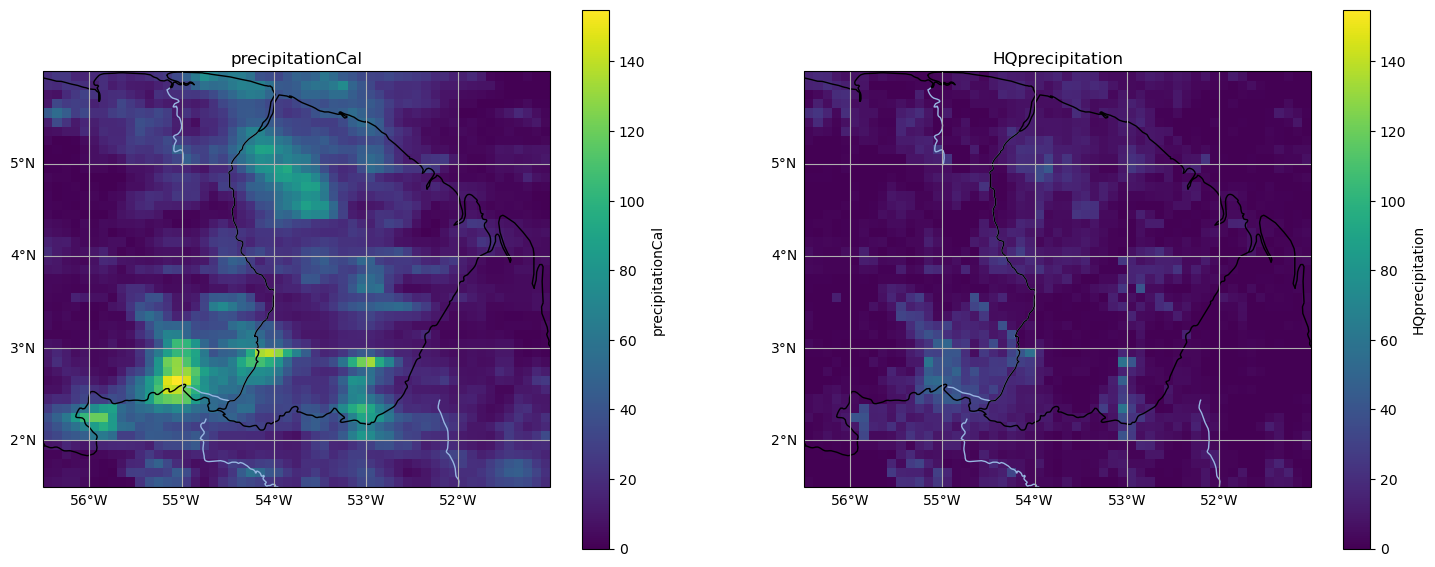

In [8]:
gvis.plot_ds(merged_subds.sum(dim='time'))